In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [2]:
import os
from typing import List
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from pprint import pprint
import copy
from tqdm.notebook import tqdm

from weac_2.analysis import Analyzer, CriteriaEvaluator, CoupledCriterionResult, SSERRResult
from weac_2.core.system_model import SystemModel
from weac_2.components import ModelInput, Segment, ScenarioConfig, WeakLayer, Layer, CriteriaConfig
from weac_2.utils.snowpilot_parser import SnowPilotParser, convert_to_mm, convert_to_deg

In [ ]:
# Process multiple files
file_paths = []
for directory in os.listdir("data/snowpits"):
    for file in os.listdir(f"data/snowpits/{directory}"):
        if file.endswith(".xml"):
            file_paths.append(f"data/snowpits/{directory}/{file}")

paths: List[str] = []
parsers: List[SnowPilotParser] = []

for file_path in file_paths:
    snowpilot_parser = SnowPilotParser(file_path)
    paths.append(file_path)
    parsers.append(snowpilot_parser)

print(f"\nFound {len(paths)} files")




Found 31170 files

Found 945 pits near avalanche

Found 848 pits near avalanche with layer of concern


In [22]:
pits_near_avalanche: List[SnowPilotParser] = []
for parser in parsers:
    # Avalanche pits
    if parser.snowpit.core_info.location.pit_near_avalanche:
        # print(parser.snowpit.core_info.location.pit_near_avalanche_location)
        pits_near_avalanche.append(parser)

print(f"\nFound {len(pits_near_avalanche)} pits near avalanche")

avalanche_pits_with_layer_of_concern: List[SnowPilotParser] = []
for pit in pits_near_avalanche:
    if pit.snowpit.snow_profile.layer_of_concern:
        # print(pit.snowpit.snow_profile.layer_of_concern)
        avalanche_pits_with_layer_of_concern.append(pit)

print(f"\nFound {len(avalanche_pits_with_layer_of_concern)} pits near avalanche with layer of concern")



Found 945 pits near avalanche

Found 848 pits near avalanche with layer of concern


In [27]:
pit_info_list = []
for pit in avalanche_pits_with_layer_of_concern:
    depth_top = pit.snowpit.snow_profile.layer_of_concern.depth_top
    if depth_top:
        depth_top_mm = depth_top[0] * convert_to_mm[depth_top[1]]
    else:
        depth_top_mm = None
    thickness = pit.snowpit.snow_profile.layer_of_concern.thickness
    if thickness:
        thickness_mm = thickness[0] * convert_to_mm[thickness[1]]
    else:
        thickness_mm = None
    slope_angle = pit.snowpit.core_info.location.slope_angle
    if slope_angle:
        slope_angle_deg = slope_angle[0] * convert_to_deg[slope_angle[1]]
    else:
        slope_angle_deg = None
    hs = pit.snowpit.snow_profile.hs
    if hs:
        hs_mm = hs[0] * convert_to_mm[hs[1]]
    else:
        hs_mm = None
    profile_depth = pit.snowpit.snow_profile.profile_depth
    if profile_depth:
        profile_depth_mm = profile_depth[0] * convert_to_mm[profile_depth[1]]
    else:
        profile_depth_mm = None
    pit_near_avalanche_location = pit.snowpit.core_info.location.pit_near_avalanche_location
    pit_info_dict = {
        "Slope Angle": slope_angle_deg,
        "HS": hs_mm,
        "Profile Depth": profile_depth_mm,
        "Pit Near Avalanche Location": pit_near_avalanche_location,
        "WL_Depth": depth_top_mm,
        "WL_Thickness": thickness_mm,
    }
    pit_info_list.append(pit_info_dict)

print(pit_info_list)

[{'Slope Angle': '23', 'HS': None, 'Profile Depth': 1000.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 800.0, 'WL_Thickness': 10.0}, {'Slope Angle': '42', 'HS': 930.0, 'Profile Depth': 930.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 390.0, 'WL_Thickness': 10.0}, {'Slope Angle': '28', 'HS': 1350.0, 'Profile Depth': 1350.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 300.0, 'WL_Thickness': 10.0}, {'Slope Angle': '24', 'HS': 740.0, 'Profile Depth': 740.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 480.0, 'WL_Thickness': 260.0}, {'Slope Angle': '28', 'HS': 2000.0, 'Profile Depth': 1250.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 90.0, 'WL_Thickness': 290.0}, {'Slope Angle': '27', 'HS': 1750.0, 'Profile Depth': 1750.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 1170.0, 'WL_Thickness': 10.0}, {'Slope Angle': '38', 'HS': 710.0, 'Profile Depth': 710.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 350.0, 'WL_Thickness': 10.0}, {'Sl

In [28]:
# Setup standard values
wl_spacing = 50 # mm
phi = 0.0
standard_scenario_config = ScenarioConfig(system_type="skier", phi=phi)
standard_weak_layer = WeakLayer(rho=125, h=20, E=1.0, sigma_c=6.16, tau_c=5.09)
standard_segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
standard_criteria_config = CriteriaConfig()
standard_criteria_evaluator = CriteriaEvaluator(standard_criteria_config)

In [36]:
def eval_avalanche_pit(parser: SnowPilotParser, pit_info_dict: dict, scenario_config: ScenarioConfig, segments: list[Segment], weaklayer: WeakLayer):
    # Extract layers
    layers, density_method = parser.extract_layers()
    heights = np.cumsum([layer.h for layer in layers])
    
    wl_depth = pit_info_dict["WL_Depth"]
    mask = heights <= wl_depth
    new_layers = [layer for layer, keep in zip(layers, mask) if keep]
    # Add truncated layer if needed
    depth = np.sum([layer.h for layer in new_layers]) if new_layers else 0.0
    if depth < wl_depth:
        additional_layer = copy.deepcopy(layers[len(new_layers) if new_layers else 0])
        additional_layer.h = wl_depth - depth
        new_layers.append(additional_layer)
    
    try:
        model_input = ModelInput(
            weak_layer=weaklayer,
            layers=new_layers,
            scenario_config=scenario_config,
            segments=segments,
        )
        system = SystemModel(model_input=model_input)
        
        cc_result: CoupledCriterionResult = standard_criteria_evaluator.evaluate_coupled_criterion(system, print_call_stats=False)
        sserr_result: SSERRResult = standard_criteria_evaluator.evaluate_SSERR(system, vertical=False, print_call_stats=False)

        pit_info_dict["impact_criterion"] = cc_result.initial_critical_skier_weight
        pit_info_dict["coupled_criterion"] = cc_result.critical_skier_weight
        pit_info_dict["sserr_result"] = sserr_result.SSERR
        pit_info_dict["touchdown_distance"] = sserr_result.touchdown_distance
    except Exception as e:
        print(f"Error processing pit {parser.snowpit.core_info.pit_id}: {e}")
        
    return pit_info_dict, layers, weaklayer

In [37]:
data_rows = []
error_pits = []
for pit, pit_info_dict in tqdm(zip(avalanche_pits_with_layer_of_concern, pit_info_list), total=len(avalanche_pits_with_layer_of_concern), desc="Processing avalanche pits"):
    try:
        pit_info_dict, layers, weaklayer = eval_avalanche_pit(
            pit, 
            pit_info_dict, 
            standard_scenario_config, 
            standard_segments, 
            standard_weak_layer)
        data_rows.append(pit_info_dict)
    except Exception as e:
        error_pits.append(pit)
        print(f"Error processing pit {pit.snowpit.core_info.pit_id}: {e}")
        continue

print(f"Number of pits with errors: {len(error_pits)}")
print(f"Number of pits processed: {len(data_rows)}")
print(f"Number of pits total: {len(avalanche_pits_with_layer_of_concern)}")

df = pd.DataFrame(data_rows)
print(df.head())

Processing avalanche pits:   0%|          | 0/848 [00:00<?, ?it/s]

Error processing pit 21585: 1 validation error for ModelInput
  Value error, At least one layer is required [type=value_error, input_value={'weak_layer': WeakLayer(...oundation=True, m=0.0)]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
Error processing pit 21142: Layer is missing density information; density profile, hand hardness and grain type are all missing. Excluding SnowPit from calculations.
Error processing pit 17994: 1 validation error for ModelInput
  Value error, At least one layer is required [type=value_error, input_value={'weak_layer': WeakLayer(...oundation=True, m=0.0)]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
Error processing pit 24190: Layer is missing density information; density profile, hand hardness and grain type are all missing. Excluding SnowPit from calculations.
Error processing pit 27244: 1 validation error for ModelInput
  Value error, At least 

In [47]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["impact_criterion"], mode="markers", name="Impact Criterion", marker=dict(color="red")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Impact Criterion")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["coupled_criterion"], mode="markers", name="Coupled Criterion", marker=dict(color="blue")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Coupled Criterion")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["sserr_result"], mode="markers", name="SSERR", marker=dict(color="green")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="SSERR")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["touchdown_distance"], mode="markers", name="Touchdown Distance", marker=dict(color="yellow")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Touchdown Distance")
fig.show()


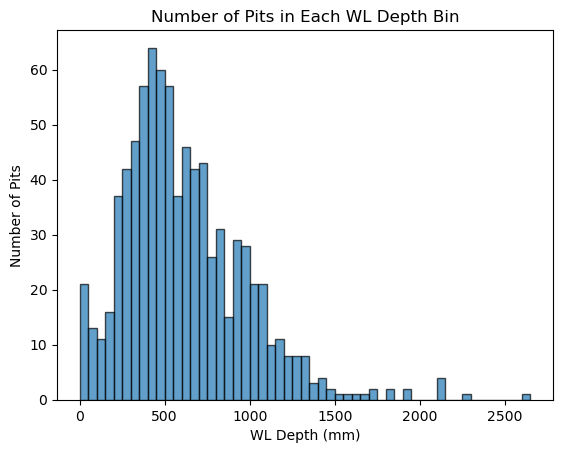

In [46]:
import matplotlib.pyplot as plt

# Bin wl depths according to 10 mm intervals
wl_depths = df["WL_Depth"]
max_wl_depth = max(wl_depths)
min_wl_depth = min(wl_depths)

# Create bins
bin_width = 50
bins = np.arange(min_wl_depth, max_wl_depth + bin_width, bin_width)

# Use matplotlib's histogram which handles this automatically
plt.hist(wl_depths, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("WL Depth (mm)")
plt.ylabel("Number of Pits")
plt.title("Number of Pits in Each WL Depth Bin")
plt.show()